<h1><center>Physique numérique (PHY-3500) - TP3</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [23]:
from typing import Callable

import numpy as np
from numba import njit
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from astropy import constants as cte
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftshift, ifftshift


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Atténuation des rayons X

1) Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de
données XCOM du NIST 1, trouvez le µ de l’eau pour des photons de 60 keV, à une
masse volumique de 1.0 g/cm3. Quelle fraction du signal subsiste après avoir traversé 5 cm d’eau ; 20 cm d’eau ?


# Reconstruction par rétroprojection

2) En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée
laminogramme, des données de projection fournies. Notez qu’une approche par slicing
pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin
pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le
voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur).
Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction.
Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image
de référence (fantôme) ?


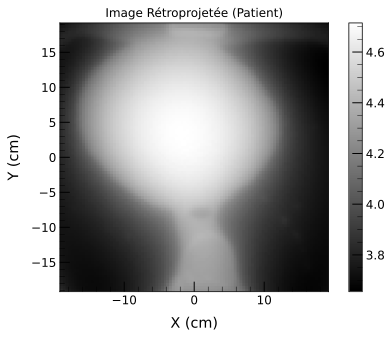

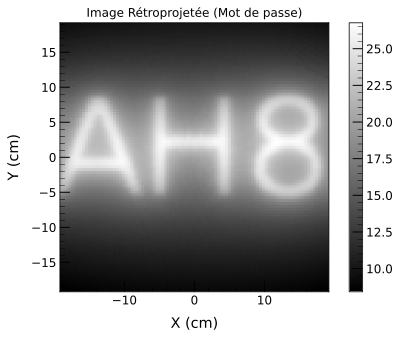

In [34]:
def retroprojection(sinogram, angles, image_size, pixel_size):
    num_projections, num_detectors = sinogram.shape
    image = np.zeros((image_size, image_size))
    isocenter = image_size * pixel_size / 2
    x = np.linspace(-isocenter, isocenter, image_size)
    y = np.linspace(-isocenter, isocenter, image_size)
    X, Y = np.meshgrid(x, y)

    for i, angle in enumerate(angles):
        radians = np.deg2rad(angle)
        t = X*np.cos(radians) + Y*np.sin(radians)
        detector_positions = np.linspace(-num_detectors * pixel_size / 2,
                                         num_detectors * pixel_size / 2, num_detectors)
        interpolator = interp1d(detector_positions, sinogram[i], kind='nearest', fill_value="extrapolate")
        projection_values = interpolator(t)
        image += projection_values

    image /= len(angles)
    return image


sinogram_patient = np.loadtxt('Data/sinogram-patient.txt')
sinogram_password = np.loadtxt('Data/sinogram-password.txt')
angles = np.loadtxt('Data/angles.txt')


image_size = 96  
pixel_size = 0.4  


image_patient = retroprojection(sinogram_patient, angles, image_size, pixel_size)
plt.imshow(image_patient, cmap='gray', extent=[-isocenter, isocenter, -isocenter, isocenter])
plt.colorbar()
plt.title('Image Rétroprojetée (Patient)')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.show()


image_password = retroprojection(sinogram_password, angles, image_size, pixel_size)
plt.imshow(image_password, cmap='gray', extent=[-isocenter, isocenter, -isocenter, isocenter])
plt.colorbar()
plt.title('Image Rétroprojetée (Mot de passe)')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.show()

# Rétroprojection filtrée

3) En utilisant la librairie numpy.fft, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré ?


4) Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant
idéalement le code précédent du laminogramme. Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Ou sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs ?


# Reconstruction via le théorème de la tranche de Fourier

5) Ecrivez une nouvelle fonction de reconstruction reconFourierSlice() qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effecteur la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l’espace de Fourier 2D de l’image à reconstruire. Vous pouvez choisir l’angle approprié par la méthode du plus proche voisin et la position sur le d´etecteur par interpolation linéaire. Trouvez l’image par TF−1 2D et commentez les résultats. Indice : considérez toutes les données comme des nombres
complexes avec l’initialisation suivante mymatrix = numpy.zeros((a,b), ’complex’), puis prenez la partie réelle de l’image finale.